# Thomas Mcdonnell Quant Trading Strategies Homework Three: Quantile Trading

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import pandas_market_calendars as mcal
from plotnine import *
from plotnine.data import *
from pandas import DateOffset
import patchworklib as pw

import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

In [2]:
FR = pd.read_csv("C:/Users/thoma/Downloads/ZACKS_FR_2_f40c6a304f87d9f492c1f21839d474e2\ZACKS_FR_2_f40c6a304f87d9f492c1f21839d474e2.csv")
FR['per_end_date'] = pd.to_datetime(FR['per_end_date'])
start_date = datetime(2014, 6, 1)
FR = FR[FR['per_end_date'] >= start_date]
end_date = datetime(2022, 1, 31)
FR = FR[FR['per_end_date'] <= end_date]
FR = FR.set_index('ticker')

#Drop all of the tickers that don't have quarterly data
FR = FR[FR['per_type'] == 'Q']

FC = pd.read_csv("C:/Users/thoma\Downloads\ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b/ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b.csv")

FC = FC[['ticker','zacks_sector_code', 'per_end_date', 'filing_date']]

FC = FC.drop_duplicates(subset = 'ticker')

#Drop all tickers in the finance, industry and auto sector

FC = FC[~FC['zacks_sector_code'].isin([5.0, 13.0])]
FC = FC.set_index('ticker')

common_tickers = set(FC.index).intersection(set(FR.index))
FR = FR.loc[common_tickers]\

FR['tot_debt_tot_equity'] = pd.to_numeric(FR['tot_debt_tot_equity'])

grouped = FR.groupby('ticker')

# Count the number of rows where tot_debt_tot_equity is greater than 0.1
counts = grouped['tot_debt_tot_equity'].apply(lambda x: (x > 0.1).sum())

# Filter out the tickers that don't have more than 85% of their rows with tot_debt_tot_equity greater than 0.1
FR = grouped.filter(lambda x: (x['tot_debt_tot_equity'] > 0.1).sum() > len(x)*.85)

FR = FR.reset_index()

FC = pd.read_csv("C:/Users/thoma\Downloads\ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b/ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b.csv")
FC = FC[['ticker', 'per_type','per_end_date', 'filing_date', 'tot_lterm_debt', 'net_lterm_debt', 'eps_diluted_net']]

FC = FC[FC['per_type'] == 'Q']

FC['per_end_date'] = pd.to_datetime(FC['per_end_date'])
FC['filing_date'] = pd.to_datetime(FC['filing_date'])
merged_df = pd.merge(FR, FC, on=['per_end_date', 'ticker'])
merged_df = merged_df.drop_duplicates()

merged_df = merged_df.set_index('ticker')

merged_df = merged_df.dropna(subset=['filing_date'])

unique_tickers = merged_df.index.unique()

ticker_counts = {}
for ticker in tqdm(unique_tickers):
    # Get the number of rows for the current ticker
    num_rows = merged_df.loc[merged_df.index == ticker].shape[0]
    # Add the ticker and number of rows to the dictionary
    ticker_counts[ticker] = num_rows

#drop all tickers where they dont have at least 31 instances of data
tickers_to_drop = [ticker for ticker in ticker_counts if ticker_counts[ticker] != 31]

# Drop rows where the 'ticker' column is in the list of tickers to drop
merged_df = merged_df[~merged_df.index.isin(tickers_to_drop)]
FR
unique_tickers = merged_df.index.unique().tolist()

tickers_to_remove = ['SWIOU', 'GEF.B' 'SENEB', 'BUKS', 'NUVR', 'INRD', 'TMS.', 'GBCS', 'UNIR', 'JANL', 'STCC', 'SMID', 'TPCS', 'TDSNA', 'BVHBB', 'BGSF']

tickers = [x for x in unique_tickers if x not in tickers_to_remove]

merged_df = merged_df.loc[tickers]

merged_df = merged_df[['per_end_date', 'filing_date', 'tot_debt_tot_equity', 'ret_invst', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net']]

filtered_df = merged_df[merged_df.index.isin(tickers)]

SHRS = pd.read_csv("C:/Users/thoma/Downloads/ZACKS_SHRS_2_99db6fa97ac677f3c0d45a9fa9a70196\ZACKS_SHRS_2_99db6fa97ac677f3c0d45a9fa9a70196.csv")
SHRS = SHRS[['ticker', 'per_end_date', 'shares_out']]

SHRS = SHRS.set_index('ticker')

MKTV = pd.read_csv("C:/Users/thoma/Downloads/ZACKS_MKTV_2_ecb7f768974bbdd26964caefe2fd0378\ZACKS_MKTV_2_ecb7f768974bbdd26964caefe2fd0378.csv")
MKTV = MKTV[['ticker', 'per_end_date', 'mkt_val']]

MKTV['per_end_date'] = pd.to_datetime(MKTV['per_end_date'])

filtered_df = pd.merge(filtered_df, MKTV, left_on = ['ticker', 'per_end_date'], right_on = ['ticker', 'per_end_date'])

#turning EPS pos
filtered_df.loc[:, 'eps_diluted_net'] = filtered_df.loc[:, 'eps_diluted_net'].where(filtered_df.loc[:, 'eps_diluted_net'] >= 0, 0.001)

filtered_df = filtered_df.set_index('ticker')

filtered_df['filing_date'] = filtered_df['filing_date'] + DateOffset(days=1)



100%|██████████| 1892/1892 [00:02<00:00, 829.06it/s]


In [3]:
eod_price = pd.DataFrame()
for ticker in tqdm(unique_tickers):
    df =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = [ticker], api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                    date = { 'gte': '2014-08-01', 'lte': '2022-02-01' }, 
                     paginate=True)
    eod_price = eod_price.append(df)
eod_price = eod_price.set_index('date')


100%|██████████| 1012/1012 [07:33<00:00,  2.23it/s]


In [15]:
eod_price = eod_price.sort_values(by='date')

filtered_df = filtered_df.sort_values(by = 'filing_date')
filtered_df['date'] = filtered_df['filing_date']

n =pd.merge_asof(eod_price, filtered_df, by = 'ticker', left_on = 'date', right_on = 'date')

tickers = n['ticker'].unique().tolist()

n = n.set_index('ticker')

n['net_lterm_debt'] = n['net_lterm_debt'].fillna(n['tot_lterm_debt'])
n['net_lterm_debt'] = n['net_lterm_debt'].fillna(0)

for ticker in tqdm(n.index.unique()):
    if n.loc[ticker].isna().any().any():
        n = n.drop(ticker)

tickers = n.index.unique().tolist()

n = n.loc[tickers]

f = pd.DataFrame()
for ticker in tqdm(tickers):
    df = n.loc[ticker]
    df = df.merge(df, left_on='per_end_date', right_on='date', how = 'outer').ffill()
    df = df.rename(columns = {'adj_close_y': 'per_end_price'})
    df['debt_to_market_cap'] = df['tot_debt_tot_equity_x']*df['per_end_price']/df['adj_close_x']
    df['price_to_earnings'] = df['adj_close_x']/df['eps_diluted_net_x']
    df['R'] = (df['ret_invst_x']*(df['net_lterm_debt_y'] + (df['mkt_val_x'])))
    df['ROI'] = df['R']/(df['net_lterm_debt_y']+df['mkt_val_x']*df['adj_close_x']/df['per_end_price']) 
    df['ticker'] = ticker
    df = df[['date_x', 'adj_close_x', 'debt_to_market_cap', 'price_to_earnings', 'ROI', 'ticker']]
    df = df.rename(columns = {'date_x': 'date', 'adj_close_x': 'price'})
    df = df.drop_duplicates(subset = 'date')
    f = df.append(f)

f = f.set_index('ticker')

f.to_csv('hw_3_ratio_data.csv')

100%|██████████| 280/280 [00:04<00:00, 56.71it/s]


In [18]:
final = pd.read_csv('C:/Users/thoma/OneDrive/Documents/QTS/Quant-Trading-Strategies/hw_3_ratio_data.csv')
final['date'] = pd.to_datetime(final['date'])
final = final.set_index('date')
start_date = pd.to_datetime('2015-01-01')
final = final.loc[final.index >= start_date]
final = final.reset_index()
final = final.set_index('ticker')
data = pd.read_csv('C:/Users/thoma/OneDrive/Documents/QTS/Quant-Trading-Strategies/hw_3_ratio_data.csv')
# data = pd.read_csv('/Users/tmac/Desktop/Quant-Trading-Strategies/Quant-Trading-Strategies/hw_3_ratio_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('ticker')
data['neg_price_to_earnings'] = data['price_to_earnings']*(-1)
data = data.drop(index='CMCSK', axis=0)
data = data.drop(index='KSU', axis=0)

In [19]:
total_ticks = len(data.index.unique())

In [20]:
libor = pd.read_csv("C:/Users/thoma/Downloads/3-month-libor-rate-historical-chart.csv")
# libor = pd.read_csv('/Users/tmac/Downloads/3-month-libor-rate-historical-chart.csv')

In [21]:
libor['date'] = pd.to_datetime(libor['date'])
libor = libor.set_index('date')
libor = libor.loc[libor.index >= pd.to_datetime('2015-01-01')]
date_range = pd.date_range(start='2015-01-01', end='2022-01-31')
libor = libor.reindex(date_range).ffill()
libor['repo'] = libor[' value'] - 1


In [22]:
data = data.reset_index()
data = data.set_index('date')
start_date = pd.to_datetime('2015-01-01')
data = data.loc[data.index >= start_date]
end_date = pd.to_datetime('2022-01-31')
data = data.loc[data.index <= end_date]
data = data.sort_index()
dates = data.index.unique()

In [23]:
def quantile_trading(financial_ratio, quantile_long, quantile_short, initial_k):
    final = pd.DataFrame(columns = ['date', 'pnl_by_date', 'total_pnl'])
    final.loc[0] = [pd.to_datetime('2015-01-04'), 0, 0]
    pnl = 0
    k = initial_k
    for i, day in enumerate(dates):
        day = day.normalize()
        day = day.tz_localize(None)
        if day == pd.to_datetime('2022-01-31'):
            #final close out of position
            #long
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_long]
            df =df.join(push_long)
            df['val'] = df['price']*df['shares']
            curr_value_long = df['val'].sum()
            pnl_today = curr_value_long - initial_long_value

            #short
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_short]
            df = df.join(push_short)
            df['val'] = df['price']*df['shares']
            curr_value_short = df['val'].sum()
            pnl_today += initial_short_value - curr_value_short + (initial_short_value*libor_td/365)

            k += pnl_today
            pnl+=pnl_today
           
            final.loc[len(final)] = [day, pnl_today, pnl]

        elif i == 0 or (day.month != dates[i-1].month and dates[i-1].day > 20):
            # long
            df = data.loc[day]
            top_ten_percent = df[df[financial_ratio] >= df[financial_ratio].quantile(quantile_long)]
            top_ten_percent = top_ten_percent.set_index('ticker')
            initial_long_value = k/20
            position_per_asset_long = initial_long_value/len(top_ten_percent.index)
            ticks_long = top_ten_percent.index.unique().to_list()
            top_ten_percent['shares'] = position_per_asset_long/top_ten_percent['price']
            push_long = top_ten_percent['shares']
            
            #short
            df = data.loc[day]
            bottom_ten_percent = df[df[financial_ratio] <= df[financial_ratio].quantile(quantile_short)]
            bottom_ten_percent = bottom_ten_percent.set_index('ticker')
            initial_short_value = k/20
            position_per_asset_short = initial_short_value/len(bottom_ten_percent.index)
            ticks_short = bottom_ten_percent.index.unique().to_list()
            bottom_ten_percent['shares'] = position_per_asset_short/bottom_ten_percent['price']
            push_short = bottom_ten_percent['shares']

            #repo rate
            libor_td = libor.loc[day]['repo']

        elif day.month != dates[i+1].month:
            #long
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_long]
            df =df.join(push_long)
            df['val'] = df['price']*df['shares']
            curr_value_long = df['val'].sum()
            pnl_today = curr_value_long - initial_long_value 

            #short
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_short]
            df = df.join(push_short)
            df['val'] = df['price']*df['shares']
            curr_value_short = df['val'].sum()
            pnl_today += initial_short_value - curr_value_short  + (initial_short_value*libor_td/365)

            k += pnl_today
            pnl+=pnl_today
            

            final.loc[len(final)] = [day, pnl_today, pnl]
    
            pnl_today += initial_short_value - curr_value_short 
    
    return final

        
  

In [166]:
data['dtmc/mean'] = data['debt_to_market_cap']/(data['debt_to_market_cap'].mean())
data['roi/mean'] = data['ROI']/(data['ROI'].mean())
data['pte/mean'] = data['neg_price_to_earnings']/(data['neg_price_to_earnings'].mean())
data['WA'] = (data['dtmc/mean'] + data['roi/mean'] - data['pte/mean'])/3

Optimize based on quantiles for debt to market cap

In [ ]:
d = -1000000000
for i in tqdm(range(70,99)):
    for j in range(1,30):
        x = quantile_trading('debt_to_market_cap', i/100, j/100, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('debt_to_market_cap', i/100, j/100, 1000000)
params

100%|██████████| 29/29 [05:23<00:00, 11.15s/it]


('debt_to_market_cap', 0.87, 0.27, 1000000)

In [24]:
debt_to_market_cap_optimal = quantile_trading('debt_to_market_cap', .87, .28, 1000000)

Optimize based on quantiles for return on equity

In [ ]:
d = -1000000000
for i in tqdm(range(70,99)):
    for j in range(1,30):
        x = quantile_trading('ROI', i/100, j/100, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('ROI', i/100, j/100, 1000000)
params

100%|██████████| 29/29 [05:24<00:00, 11.20s/it]


('ROI', 0.98, 0.29, 1000000)

In [25]:
roi_optimal = quantile_trading('ROI', .98, .29, 1000000)

optimize based on quantiles for price to earnings

In [ ]:
d = -1000000000
for i in tqdm(range(70,99)):
    for j in range(1,30):
        x = quantile_trading('neg_price_to_earnings', i/100, j/100, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('neg_price_to_earnings', i/100, j/100, 1000000)
params

100%|██████████| 29/29 [05:23<00:00, 11.16s/it]


('neg_price_to_earnings', 0.96, 0.06, 1000000)

In [26]:
price_to_earnings_optimal = quantile_trading('neg_price_to_earnings', .96, .06, 1000000)

In [73]:
price_to_earnings_optimal['Line Type'] = 'red'
roi_optimal['Line Type'] = 'blue'
debt_to_market_cap_optimal['Line Type'] = 'green'

price_to_earnings_optimal['percent_profit'] = ((price_to_earnings_optimal['total_pnl'] +  1000000)/ 1000000 - 1)*100
roi_optimal['percent_profit'] = ((roi_optimal['total_pnl'] +  1000000)/ 1000000 - 1)*100
debt_to_market_cap_optimal['percent_profit'] = ((debt_to_market_cap_optimal['total_pnl'] +  1000000)/ 1000000 - 1)*100

Differenced Ratios

In [77]:
data['differenced_debt_to_market_cap'] = data['debt_to_market_cap'].diff(periods = 21)
data['differenced_roi'] = data['ROI'].diff(periods = 21)
data['differenced_neg_price_to_earnings'] = data['neg_price_to_earnings'].diff(periods = 21)

In [167]:
normalized_average = quantile_trading('WA', .1, .1, 1000000)

In [78]:

debt_to_market_cap_ten = quantile_trading('debt_to_market_cap', .9, .1, 1000000)
roi_ten = quantile_trading('ROI', .9, .1, 1000000)
price_to_earnings_ten = quantile_trading('neg_price_to_earnings', .9, .1, 1000000)

price_to_earnings_ten['Line Type'] = 'red'
roi_ten['Line Type'] = 'blue'
debt_to_market_cap_ten['Line Type'] = 'green'

differenced_debt_to_market_cap_ten = quantile_trading('differenced_debt_to_market_cap', .9, .1, 1000000)
differenced_roi_ten = quantile_trading('differenced_roi', .9, .1, 1000000)
differenced_price_to_earnings_ten = quantile_trading('differenced_neg_price_to_earnings', .9, .1, 1000000)

differenced_price_to_earnings_ten['Line Type'] = 'red'
differenced_roi_ten['Line Type'] = 'blue'
differenced_debt_to_market_cap_ten['Line Type'] = 'green'

price_to_earnings_ten['percent_profit'] = ((price_to_earnings_ten['total_pnl'] +  1000000)/ 1000000 - 1)*100
roi_ten['percent_profit'] = ((roi_ten['total_pnl'] +  1000000)/ 1000000 - 1)*100
debt_to_market_cap_ten['percent_profit'] = ((debt_to_market_cap_ten['total_pnl'] +  1000000)/ 1000000 - 1)*100



# 1 DATA

As with many quantitative trading projects, the most difficult and potentially most important part is gathering and cleaning accurate data on which to backtest on. In this assignment the primary data source that we used were ZACK's fundamental tables on Nasdaq Data Link along with QUOTEMEDIA for end of day equity prices. The dfferent tables in ZACK's funadmentals consisted of a lot of corporate finance data such as certain ratios or statistics found in earnings reports or SEC filing. The main difficulty with this is that the majority of this data is reported either quarterly or annually, and we were seeking daily data for out trading strategy. Along with this, there were around 17,000 tickers in this dataset resulting in unruly data and filtering was needed before our trading.

The first filtering that I performed was to get rid of all data before June 2014. Even though we only needed data starting on 2015 I used June 2014 as my cutoff as some data would need to be rolled over and filled to assure that we had complete data on Jan 1 2015. Along with this, I removed every ticker that didn't have quarterly reported data as it would complicate my eventual data merging if I had both quarterly and annually reported data. I removed all data in ZACK's indistry codes 5 and 13 which corresponded to the auto industry, financial services and insurance. My hypothesis for this is that these industries may have had skewed financial ratios that would result in a lot of correlation in my eventual quantiles. As mentioned in the instruction, we were wanting tickers that had a debt/market_cap ratio of above .1 for at least part of the period. For a makeshift debt/market ratio I used the ZACK/FR table's total debt to total equity ratio. Instead of filtering for tickers with at least one entry of over .1, I decided to filter further by only keeping tickers who had a total debt to equity ratio over .1 for over 85% of all reporting dates.

A large issue that I encountered in this data merging was that only  the ZACK/FC table had a 'filing date' columm. The importance of the filing date is that the following day is the day that the public knows the new data. For example, if a period end date was March 30th, but the corresponding filing date was June 3rd, data will not be known to effect the market until June 4th. Therefore I needed to have a filing date for all of my data, So i merged my other tables with ZACKS/FC on the period end date and ticker so that I now had a corresponding filing date for every period end date for every ratio. This left me with 1,892 unique tickers. 

My next filter dealt with the impending issue of missing data during my trading simulation. I didn't want any data where a certain period end date or filing date was skipped as it would result in incorrect data being filled forwards and altering my trading results. To deal with this, I dropped every ticker that didn't have exactly 31 instances of data during this time period. The 31 coming from 7 years * 4 quarters + 3 extra before 2014 and after 2021. 

After having a clean, filtered and merged version of ZACK's fundamental tables it was time to recieve price data. I used adjusted close price data from 2015 until 2022 for all tickers that I had which was about 1012 equities. Using this data, I utilized pandas "merge_asof" function which merges data on nearest keys instead of equal keys. This was very helpful as many filing dates were not trading days, and therefore didn't exist in my price dataset. As my final filter I dropped all tickers who had NA values anywhere in the dataframe. After this merge and filter I had my final data set with around 1,800 dates for 972 tickers and it was now time to adjust the ratios to daily values. 


### DEBT TO MARKET CAP

As mentioned, we were given a total debt to total equity ratio by ZACK/FR, yet this had lookahead bias and wasn't updated daily. Look ahead bias is bias that results from using information "from the future" during a past simulation or backtest. For example, our total debt total equity ratio is calculated on a period end date, but the public isn't able to access it until the filing date. Lets say the filing date was June 3rd and today is June 4th and we finally recieve the total debt total equity ratio for AAPL. That ratio is not necessarily correct today because it was calculated with the price on the peroid end date, lets call it March 30th. To adjust for this, we calculate daily debt to market cap ratio as the total debt total equity ratio per filing date period multiplied by the price on March 30th (the period end date) and divided by the price on June 4th (current date).

$$D/M = (\frac{D}{M})_{6-4}*\frac{P_{3-30}}{P_{6-4}}$$

### PRICE TO EARNINGS

My price to earnings ratio had similar sentiment but a less complex calculation. It was simply price today divided by earnings per share on the period end date. Technically this ratio would be price per earnings per share

$$P/E = \frac{P_{6-4}}{E_{3-30}}$$

### RETURN ON INVESTMENT

Return on investment was by far the hardest metric to calculate. ZACK had a metric called return on investment, but again this metric had lookahead bias and would be unable to trade on accurately without adjustment. Let V equal the return on investment given by ZACK. This return on investment equals Return divided by debt plus marketcap. We need to calculate that return value before we can even adjust for price. All of this can be shown below

$$V = \frac{R}{D+M}$$

We then solve for this R and forward fill it for every date after the period end date. Then, the V each day equals the R on the period end date divided by the debt on the period end date plus todays market cap

$$V_{6-4} = \frac{R_{3-30}}{D_{3-30}+M_{6-4}}$$

where

$$M_{6-4} = M_{3-30}\frac{P_{6-4}}{P_{3-30}}$$


# 2 TRADING

The goal of this project was to perform a quantile trading strategy from 2015 to 2022 using these financial ratios for a group of at least 200 equities. I did a monthly quantile trading strategy where at the beginning of a month you would go long the equities who were the top x% in whichever financial ratio was chosen and short the bottom y% of that ratio. At the end of each month you would sell the positions that you were long in and buy back the assets that you were short, with a slight adjustment due to our repo rate (rolling 3 month libor - 100bps). After this I would append a realized PNL value to a dataframe that I would eventually return. You would continue to do this every month until the last day of the trading period on which you would also close out your positions. 

To figure out my initial position I went K/20 dollars long and short where K was my total capital so I had 10/K notional. Every month, my capital changed as I either gained or lost profit so the dollar position per month would slightly vary. For each individual equity I took the same dollar position by doing my total money long divided by the amount of equities in the quantile. 

For price to earnings, I multiplied every value by -1 as I interpreted a high price to earnings as 'bad' as perhaps the company was being overvalued. This way when I took my top decile I was taking the values that were the least negative, aka the equities that had the smallest magnitude of price to earnings

I funcitonalized this simluation so that I could alter the ratio on which we were trading, the upper quantile and the lower quantile. Having this functionalized made it easier for me to eventually optimize my quantiles and try out different parameters

# 3 ANALYSIS

Below is a plot of my returns for a basic 10% upper and bottom quantile strategy. As you can see, I made profit with debt to market cap and price to earnings, but lost a good bit on ROI. The initial capital was 1 million.

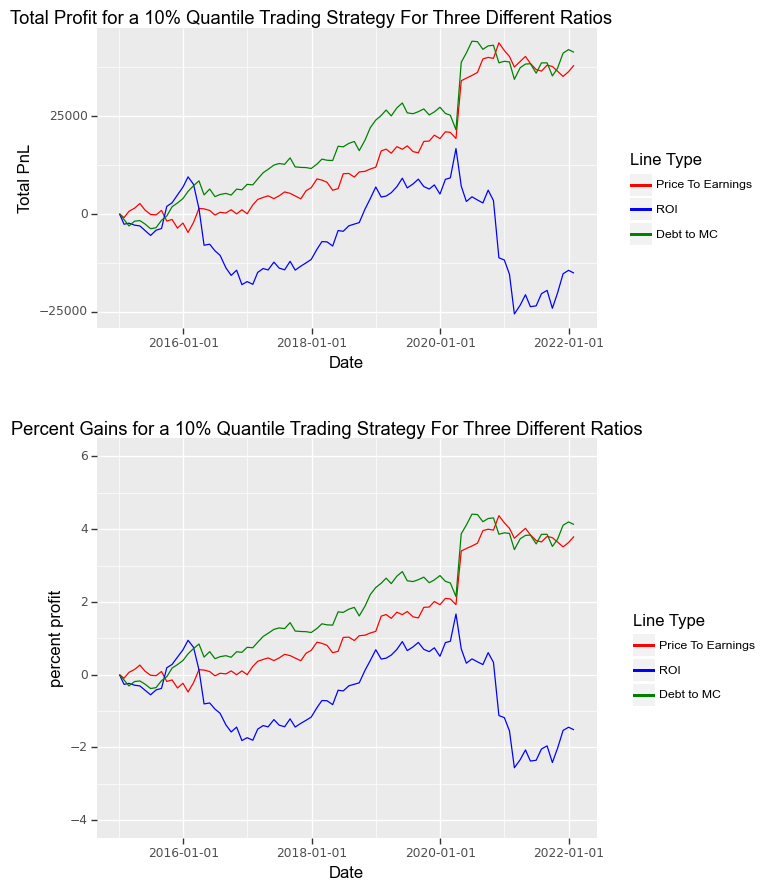

In [68]:
p1 = (ggplot(debt_to_market_cap_ten)
 + aes(x='date', y='total_pnl', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=roi_ten)
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=price_to_earnings_ten)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ggtitle("Total Profit for a 10% Quantile Trading Strategy For Three Different Ratios") 
 + xlab("Date")
 + ylab("Total PnL")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

p2 = (ggplot(debt_to_market_cap_ten)
 + aes(x='date', y='percent_profit', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='percent_profit', color = 'Line Type'), data=roi_ten)
 + geom_line(aes(x='date', y='percent_profit', color = 'Line Type'), data=price_to_earnings_ten)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ylim(-4, 6)

 + ggtitle("Percent Gains for a 10% Quantile Trading Strategy For Three Different Ratios") 
 + xlab("Date")
 + ylab("percent profit")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

p1 = pw.load_ggplot(p1, figsize=(5,3))
p2 = pw.load_ggplot(p2, figsize=(5,4))

p12 = (p1/p2)
p12.savefig()

To attempt to improve my strategy, I optimized my quantiles. That is, I found which quantile combination long and short yielded the highest profit for each strategy. I tested long quantiles from 70 to 99% and short quantiles from 1 to 30%. 

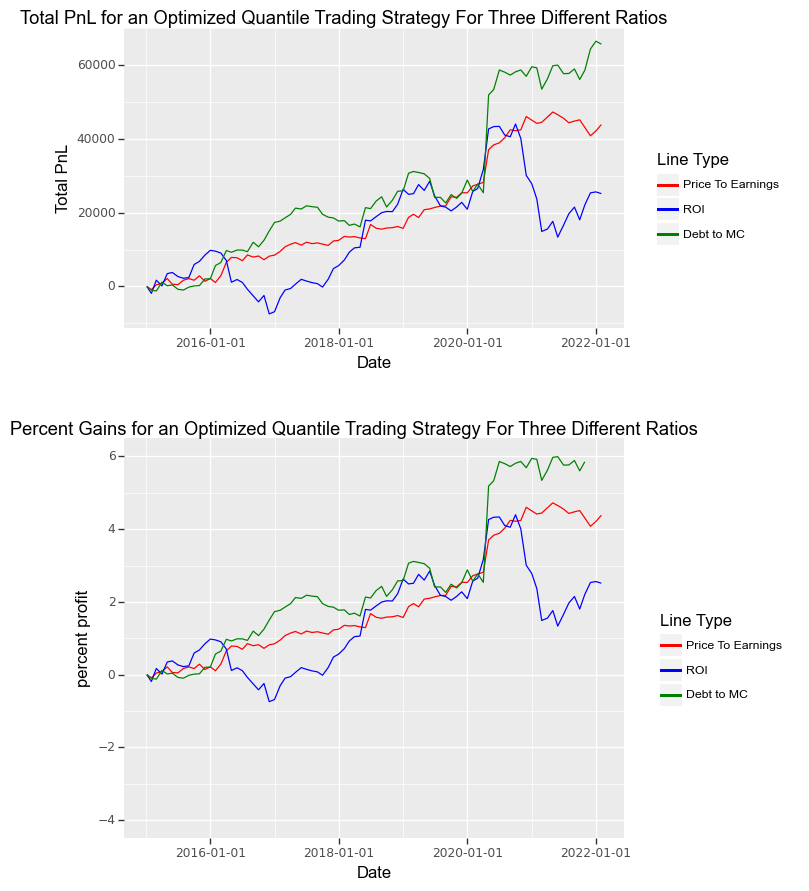

In [86]:
p1 = (ggplot(debt_to_market_cap_optimal)
 + aes(x='date', y='total_pnl', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=roi_optimal)
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=price_to_earnings_optimal)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ggtitle("Total PnL for an Optimized Quantile Trading Strategy For Three Different Ratios") 
 + xlab("Date")
 + ylab("Total PnL")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

p2 = (ggplot(debt_to_market_cap_optimal)
 + aes(x='date', y='percent_profit', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='percent_profit', color = 'Line Type'), data=roi_optimal)
 + geom_line(aes(x='date', y='percent_profit', color = 'Line Type'), data=price_to_earnings_optimal)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ylim(-4, 6)

 + ggtitle("Percent Gains for an Optimized Quantile Trading Strategy For Three Different Ratios") 
 + xlab("Date")
 + ylab("percent profit")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

p1 = pw.load_ggplot(p1, figsize=(5,3))
p2 = pw.load_ggplot(p2, figsize=(5,4))

p12 = (p1/p2)
p12.savefig()

This yielded profit for all strategies, although price ot earnings and debt to equity have profit very similar to the upper and lower deciles strategy. An issue with this optimization is that it likely is overfitting the data, which is a common issue for machine learning approaches such as this. For example, just because that is the optimal quantile in our backtest doesn't necessarily mean that it will be optimal in the future. 

Our optimal quantiles were:

debt to market cap: .87, .27

return on investment: .98, .29

price to earnings: .96, .06

Another issue with this optimization is that there are some very small and very large quantiles. For example, with debt to market cap, shorting the bottom 27% of all equities would be challenging given transiction costs and availability of shorts. With return on investment, only buying the top 2% of equities somewhat defeats the purpose of a quantile strategy as you are buying such a small amount of equities and potentially take on more risk. 

The next variant of this strategy that I tested was to trade on quantiles of the changes in each ratio. That is, I used the difference function to calculate the difference between the current dates ratio and the previous dates ratio. I used a shift of 21 days as this was the average amount of trading days per month. Below is the results of an upper and lower deciles quantile trading strategy using these differences.

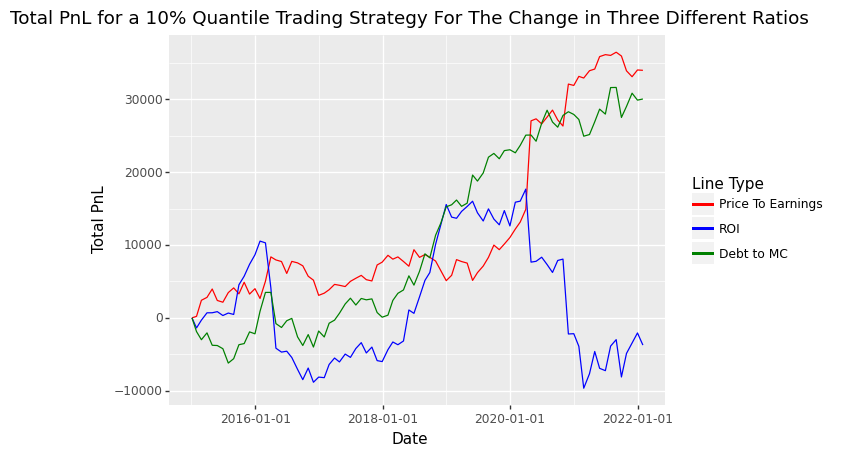

<ggplot: (119138724817)>

In [87]:
(ggplot(differenced_debt_to_market_cap_ten)
 + aes(x='date', y='total_pnl', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=differenced_roi_ten)
 + geom_line(aes(x='date', y='total_pnl', color = 'Line Type'), data=differenced_price_to_earnings_ten)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")

 + ggtitle("Total PnL for a 10% Quantile Trading Strategy For The Change in Three Different Ratios") 
 + xlab("Date")
 + ylab("Total PnL")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

Finally, I conducted my own ratio which was a combination of the three ratios. This ratio was a normalized average of the three ratios. That is, I divided every entry by the mean of that ratio, added those values up and divided by 3. For price to earnings, I used the nagetive price to earnings as a higher price to earnings likely means an overvalued company and that is 'bad' in this sense. Although unoptimized, the strategy of using this ratio for deciles did not yield profit. This is likely due to the correlation between the ratios (which I talk about below)

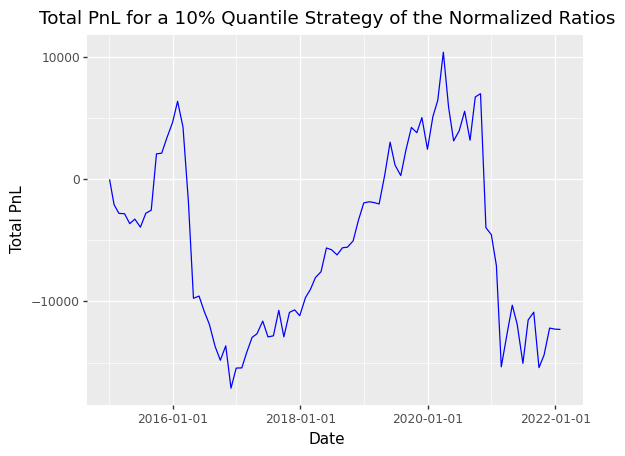

<ggplot: (118930645161)>

In [175]:
(ggplot(normalized_average)      
 + aes(x='date')   
 + geom_line(aes(y='total_pnl'), color = 'blue')
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ggtitle("Total PnL for a 10% Quantile Strategy of the Normalized Ratios") 
 + xlab("Date")
 + ylab("Total PnL")
)

### CORRELATION

In [102]:
print('correlation between debt to market cap and roi quantile strategy returns = ' + str(debt_to_market_cap_ten['total_pnl'].corr(roi_ten['total_pnl'])))

correlation between debt to market cap and roi quantile strategy returns = -0.16578512222649494


In [103]:
print('correlation between debt to market cap and price to earnings quantile strategy returns = ' + str(debt_to_market_cap_ten['total_pnl'].corr(price_to_earnings_ten['total_pnl'])))

correlation between debt to market cap and price to earnings quantile strategy returns = 0.9567023182432168


In [104]:
print('correlation between price to earnings and roi quantile strategy returns = ' + str(price_to_earnings_ten['total_pnl'].corr(roi_ten['total_pnl'])))

correlation between price to earnings and roi quantile strategy returns = -0.04926003008221059


As you can see, the quantile strategy using ROI is very uncorrelated with the other returns, although this is becasue that is the strategy that had negative overall profit. The Correlations between debt to market cap and price to earnings are extremely high though, so using these strategies at the same time may be a bad idea as you aren't hedged at all and are increasing your risk.

In [106]:
print('correlation between debt to market cap and differenced debt to market cap quantile strategy returns = ' + str(debt_to_market_cap_ten['total_pnl'].corr(differenced_debt_to_market_cap_ten['total_pnl'])))

correlation between debt to market cap and differenced debt to market cap quantile strategy returns = 0.9397658124243459


In [107]:
print('correlation between ROI and differenced ROI quantile strategy returns = ' + str(roi_ten['total_pnl'].corr(differenced_roi_ten['total_pnl'])))

correlation between ROI and differenced ROI quantile strategy returns = 0.9278994304686318


In [108]:
print('correlation between debt to market cap and differenced debt to market cap quantile strategy returns = ' + str(price_to_earnings_ten['total_pnl'].corr(differenced_price_to_earnings_ten['total_pnl'])))

correlation between debt to market cap and differenced debt to market cap quantile strategy returns = 0.9606736571202983


I expected to see results like this given how similar the return series' looked. Economically this makes sense as well. A lot of these ratios are very similar throughout all of the equities, so if a specific stock has a big jump in their ratio, they will likely be in the top quantile of the ratio regardless. Therefore, for the change in ratio strategy, we will likely be buying and shorting a lot of the same equities that we did in our initial strategy. 

### SHARPE RATIOS

In [123]:
x = debt_to_market_cap_ten['pnl_by_date'].mean()/debt_to_market_cap_ten['pnl_by_date'].std()
y = price_to_earnings_ten['pnl_by_date'].mean()/price_to_earnings_ten['pnl_by_date'].std()
z = roi_ten['pnl_by_date'].mean()/roi_ten['pnl_by_date'].std()
sharpe = pd.DataFrame({'strategy': ['debt to market cap decile', 'price to earnings decile', 'roi decile'], 'sharpe ratio':[x, y, z]})
sharpe = sharpe.set_index('strategy')
sharpe

,sharpe ratio
strategy,
debt to market cap decile,0.202293
price to earnings decile,0.190015
roi decile,-0.052341


In [125]:
x = debt_to_market_cap_optimal['pnl_by_date'].mean()/debt_to_market_cap_optimal['pnl_by_date'].std()
y = price_to_earnings_optimal['pnl_by_date'].mean()/price_to_earnings_optimal['pnl_by_date'].std()
z = roi_optimal['pnl_by_date'].mean()/roi_optimal['pnl_by_date'].std()
sharpe = pd.DataFrame({'strategy': ['debt to market cap optimal', 'price to earnings optimal', 'roi optimal'], 'sharpe ratio':[x, y, z]})
sharpe = sharpe.set_index('strategy')
sharpe

,sharpe ratio
strategy,
debt to market cap optimal,0.340846
price to earnings optimal,0.219802
roi optimal,0.096654


None of these strategies yield super high sharpe ratios as the highest is the optimal debt to market cap strategy. There is a lot of variance in the returns when settling the trades monthly that greatly outweigh the average returns per month.

### TAIL RISK

In [153]:
#from Mark Hendricks GITHUB
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR


    return metrics

In [158]:
x = tailMetrics(debt_to_market_cap_ten[['pnl_by_date']])
x['strategy'] = 'debt to market cap decile'
y = tailMetrics(roi_ten[['pnl_by_date']])
y['strategy'] = 'roi decile'
z = tailMetrics(price_to_earnings_ten[['pnl_by_date']])
z['strategy'] = 'price to earnings, decile'
f = x.append(y).append(z).set_index('strategy')
f

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
strategy,,,,
debt to market cap decile,3.420156,21.012116,-2020.040961,-2420.568257
roi decile,-1.522884,4.560747,-5801.507229,-9995.329838
"price to earnings, decile",3.210048,22.422852,-3130.853278,-3918.474070


Debt to market cap and price to earnings having positive skew makes sense as this basically means that there were more days with positive returns than their were days with negative returns. For Roi this negative makes sense for the exact same rason as the overall profit was negative.

A 'normal' kurtosis is around 3. Therefore all of these tails are leptokurtic meaning they are very condensed and centered with skinny tails. ROI is almost normal, so it means that the returns are very spread out and not all similar to the mean. For debt to market cap and price to earnings, having a kurtosis greater than 20 means that practically all of the data is centered in a small range with a few large outliers. 

To show this, below I have plotted the pnl by date instead of total pnl

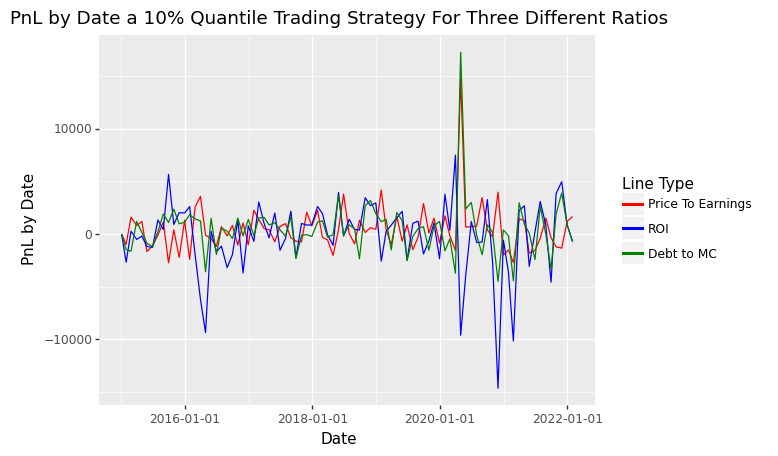

<ggplot: (119150275125)>

In [160]:
(ggplot(debt_to_market_cap_ten)
 + aes(x='date', y='pnl_by_date', color = 'Line Type')
 + geom_line()
 + geom_line(aes(x='date', y='pnl_by_date', color = 'Line Type'), data=roi_ten)
 + geom_line(aes(x='date', y='pnl_by_date', color = 'Line Type'), data=price_to_earnings_ten)
 + scale_x_date(date_breaks = "2 years", date_labels = "%Y-%m-%d")
 + ggtitle("PnL by Date a 10% Quantile Trading Strategy For Three Different Ratios") 
 + xlab("Date")
 + ylab("PnL by Date")
 + scale_color_manual(name='Line Type', labels=['Price To Earnings', 'ROI', 'Debt to MC'], values=['Red', 'Blue', 'Green'])
)

As mentioned above, ROI has more daily pnl below zero, resulting in a negative skew and price to earnings and debt to market cap have more daily pnl above zero, leading to positive skew. I believe that one of the reasons that kurtosis is so high for debt to market cap and price to earnings is that one date a little after Jan 1 2020 where there is a massive spike in daily PnL. This is greatly bringing up the mean, but it is the only real 'out of the ordinary' spike for these two strategies. 

# CONCLUSIONS

The primary hardship with this project was the data collection and merging. It is really imoprtant to get this step correct as incorrect data will skew your backtesting. By the end, I had my ratios matching up perfectly with the LLY ratios given as an example.

None of these strategies yielded amazing results as the best strategy produced about 6% gain but over 7 years, which would have been out performed by the market. That being said, quantile trading can be very useful as a strategy if you can identify a specific ratio or statistic that you believe is going to contribute to gain or loss over the next month.

Improvements I could have made to this project were to attempt different time lenghts for rebalancing my portfolio. I adjusted every month, but you could adjust every week, biweekly, or any other time frame, and could pass this through an optimizer as well (although it'd likely overfit the data). Another improvement would be to deal with trading costs and frictions. This project assumed no trading costs, which in reality may be false. It will often be expensive to rebalance such a large portfolio monthly when dealing with positions long and short. We also used adjusted close as our price date which, although not too far off, will be a different price than what we would be able to buy an asset at during the trading day. Another improvement area would be to conduct deeper cleaning as there were a few ratios that seemed way too far off, likely resulting for a mistake in ZACK's fundamental data or the adjusted close price data. 